# 多项式回归

## 多项式回归模型
> 多项式回归模型是一种用于预测连续数据的统计模型。它假设数据可以表示为一系列多项式函数的加权和，其中每个多项式函数都对应于数据中的一个自变量的不同次方。通过最小化残差平方和来确定多项式函数的最佳权重，可以对数据进行拟合，并预测未来的连续值。多项式回归模型在许多领域都有广泛的应用，例如气象、金融、工程和物理学等。

### 数据导入及处理

In [2]:
import pandas as pd 
import numpy as np  #For mathematical calculatons
import seaborn as sns #For data visualization
import matplotlib.pyplot as plt # For plotting graphs
import plotly.graph_objs as go
import warnings      #To ignore warnings
warnings.filterwarnings ("ignore")
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from math import sqrt

# 分别读入处理好的训练集和测试集
train_data_path = "../datasets/train_data.csv"
test_data_path = "../datasets/test_data.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

X_train = train_data.iloc[:, :-1]  
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1]  
X_test.fillna(X_test.median(), inplace=True)
y_test = test_data.iloc[:, -1]

In [3]:
# 添加常数项
X_train = sm.add_constant(X_train)  
X_test = sm.add_constant(X_test)

In [4]:
# 创建并拟合线性回归模型
model = sm.OLS(y_train, X_train).fit()

In [5]:
# 打印模型摘要
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     446.9
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:28:35   Log-Likelihood:                -13845.
No. Observations:                1167   AIC:                         2.771e+04
Df Residuals:                    1155   BIC:                         2.778e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.439e+06   1.33e+05    -10.840   

In [6]:
# 使用模型进行预测
y_pred = model.predict(X_test)

In [7]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 26001.246989771556
mean_squared_error: 2453803926.365497
rmse: 49535.88523853689
r2 score: 0.6340292035508086


### 多项式回归函数（自己实现）

In [8]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

class LinearRegression:
    def __init__(self, data, labels, poly=1, include_bias=True, regularization=False) -> None:
        """
        初始化线性回归模型

        :param data: 输入的特征数据，形状为 (n_samples, n_features)
        :param labels: 目标变量标签，形状为 (n_samples,)
        :param poly: 多项式特征的度数，默认为1
        :param include_bias: 是否在多项式特征中包含偏置项，默认为True
        :param regularization: 是否使用正则化，默认为False
        """
        self.poly = poly
        self.include_bias = include_bias
        self.regularization = regularization
        self.cost_history = []

        # 将原始数据转换为多项式特征
        self.data = PolynomialFeatures(degree=self.poly, include_bias=self.include_bias).fit_transform(data)
        # 将标签转换为列向量
        self.labels = labels.reshape(-1, 1)

        # 初始化参数向量theta为零向量
        num_features = self.data.shape[1]
        self.theta = np.zeros((num_features, 1))

    def fit(self, lamda=None):
        """
        使用正规方程拟合模型
        
        :param lamda: 正则化参数，如果为None则不使用正则化
        :return: 更新后的参数theta
        """
        if self.regularization and lamda is not None:
            # 使用正则化的正规方程
            self.theta = np.linalg.inv(self.data.T.dot(self.data) + lamda * np.eye(self.data.shape[1])).dot(
                self.data.T).dot(self.labels)
        else:
            # 不使用正则化的正规方程
            self.theta = np.linalg.inv(self.data.T.dot(self.data)).dot(self.data.T).dot(self.labels)
        
        return self.theta

    def train(self, alpha, num_iterations=500, lamda=None):
        """
        使用梯度下降训练模型。

        :param alpha: 学习率
        :param num_iterations: 迭代次数
        :param lamda: 正则化参数
        :return: 最终的参数theta和代价历史cost_history
        """
        self.cost_history = self.gradient_descent(alpha, num_iterations, lamda)
        return self.theta, self.cost_history

    def gradient_descent(self, alpha, num_iterations, lamda=None):
        """
        执行梯度下降算法。

        :param alpha: 学习率
        :param num_iterations: 迭代次数
        :param lamda: 正则化参数
        :return: 代价历史cost_history
        """
        for _ in range(num_iterations):
            cost = self.gradient_step(alpha, lamda)
            self.cost_history.append(cost)
        return self.cost_history

    def gradient_step(self, alpha, lamda=None):
        """
        执行单个梯度下降步骤。

        :param alpha: 学习率
        :param lamda: 正则化参数
        :return: 当前迭代的代价
        """
        num_examples = self.data.shape[0]
        prediction = LinearRegression.hypothesis(self.data, self.theta)
        delta = prediction - self.labels
        if self.regularization and lamda is not None:
            gradient = (1 / num_examples) * np.dot(self.data.T, delta)
            if self.include_bias:
                # 如果包含偏置项，则不对偏置项应用正则化
                gradient[1:] -= alpha * lamda * self.theta[1:]
            else:
                gradient -= alpha * lamda * self.theta
            self.theta -= alpha * gradient
        else:
            self.theta -= alpha * (1 / num_examples) * np.dot(self.data.T, delta)

        cost = (1 / 2) * np.dot(delta.T, delta)
        return cost[0][0]

    @staticmethod
    def hypothesis(data, theta):
        """
        计算模型的预测值。

        :param data: 输入数据
        :param theta: 参数向量
        :return: 预测值
        """
        predictions = np.dot(data, theta)
        return predictions

    def predict(self, data):
        """
        对新数据进行预测。

        :param data: 新的输入数据
        :return: 预测结果
        """
        data_processed = PolynomialFeatures(degree=self.poly, include_bias=self.include_bias).fit_transform(data)
        predictions = LinearRegression.hypothesis(data_processed, self.theta)
        return predictions
    
    def plot_final_cost_history(self):
        """
        绘制训练过程中损失函数图像。

        :return: 损失函数图像
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.cost_history) + 1), self.cost_history)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost Function History')
        plt.grid(True)
        plt.show()

In [9]:
# 创建 LinearRegression 模型
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### 梯度下降法

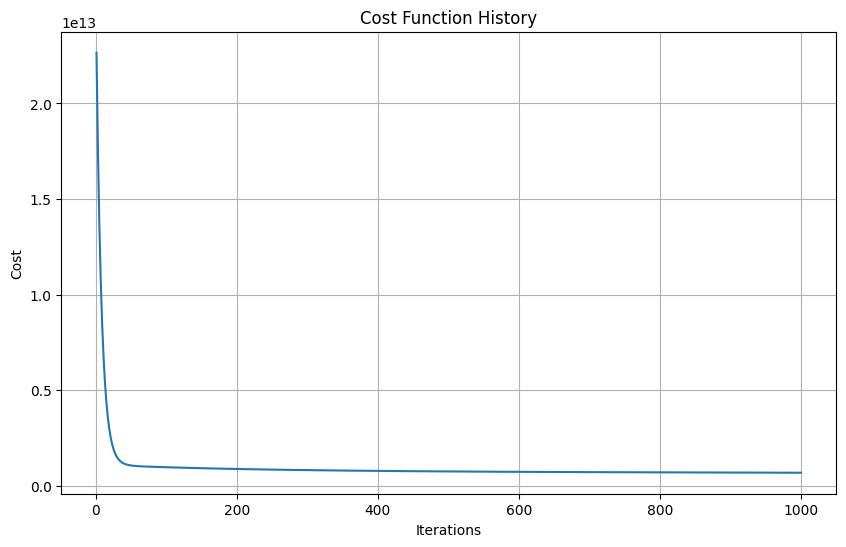

In [10]:
model = LinearRegression(X_train_scaled.values, y_train.values, poly=2, include_bias=False, regularization=True)
theta, cost_history = model.train(alpha=0.01, num_iterations=1000, lamda=0.1)
model.plot_final_cost_history()

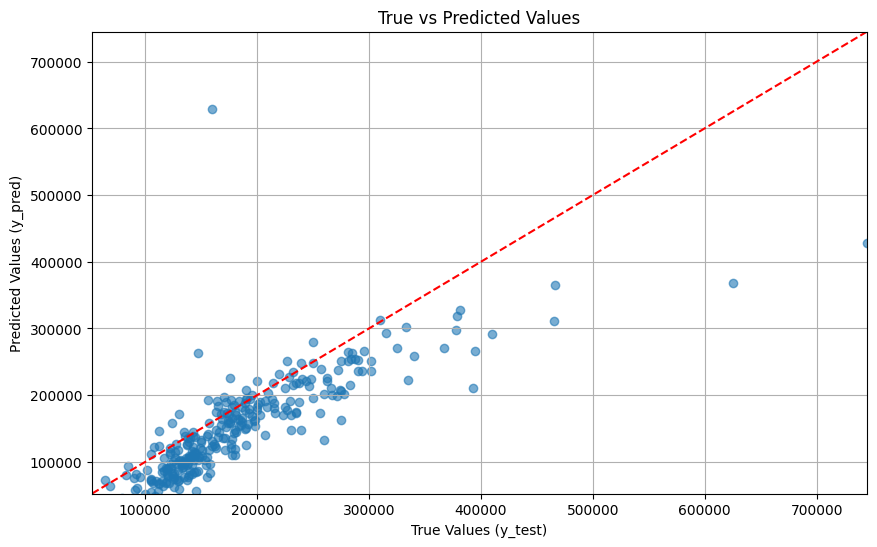

In [17]:
Y = y_test.values
y_pred = model.predict(X_test_scaled.values)
plt.figure(figsize=(10, 6))
plt.scatter(Y, y_pred, alpha=0.6)
plt.title('True vs Predicted Values')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--') # 参考线
plt.xlim(Y.min(), Y.max())
plt.ylim(Y.min(), Y.max())
plt.grid()
plt.show()


## 实验1：不同多项式特征系数
> 多项式特征系数（polynomial feature coefficients）是指在特征工程中使用的一种技术，用于将原始特征进行多项式展开。多项式展开是一种将原始特征进行非线性变换的方法，可以增加特征的维数，提高模型的拟合能力。

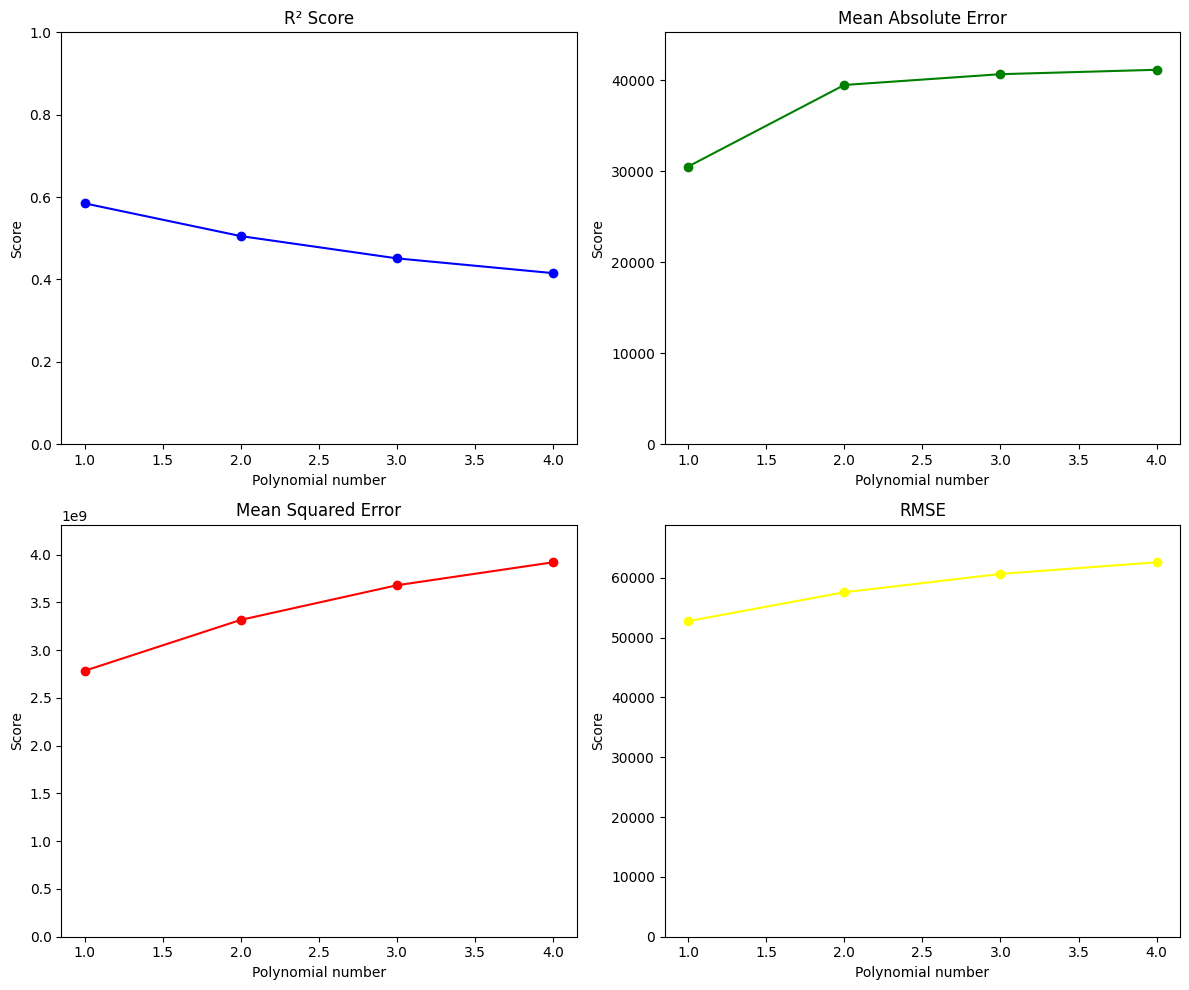

In [17]:
polys = [1,2,3,4]

r2_scores = []
mean_absolute_errors = []
mean_squared_errors = []
rmses = []
for _, poly in enumerate(polys):
    poly_model = LinearRegression(X_train_scaled.values, y_train.values, poly=poly, include_bias=False, regularization=True)
    #poly_model.fit(0.1)
    theta, cost_history = poly_model.train(alpha=0.01, num_iterations=1000, lamda=0.1)
    y_test_pred = poly_model.predict(X_test_scaled.values)
    
    #poly_model.plot_final_cost_history()
    
    r2_scores.append(r2_score(y_test.values, y_test_pred))
    mean_absolute_errors.append(mean_absolute_error(y_test.values, y_test_pred))
    mean_squared_errors.append(mean_squared_error(y_test.values, y_test_pred))
    rmses.append(sqrt(mean_squared_error(y_test.values, y_test_pred)))
    
    
# 定义评估指标及对应的标题和颜色
metrics = [r2_scores, mean_absolute_errors, mean_squared_errors, rmses]
metric_titles = ['R² Score', 'Mean Absolute Error', 'Mean Squared Error', 'RMSE']
colors = ['blue', 'green', 'red', 'yellow']  # 为每个指标分配不同的颜色

# 创建四个子图
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 绘制每个指标的折线图
for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axs[i // 2, i % 2]
    ax.plot(polys, metric, color=colors[i % len(colors)], marker='o')  # 使用不同的颜色和标记
    ax.set_title(title)
    ax.set_xlabel('Polynomial number')
    ax.set_ylabel('Score')
    ax.set_ylim(0, max(max(metric) * 1.1, 1))  # 根据最大值设置 y 轴范围

# 调整布局
plt.tight_layout()
# 显示图形
plt.show()

## 实验2：是否添加偏置项
> 偏置项（bias term）是指在模型中添加的常数项。

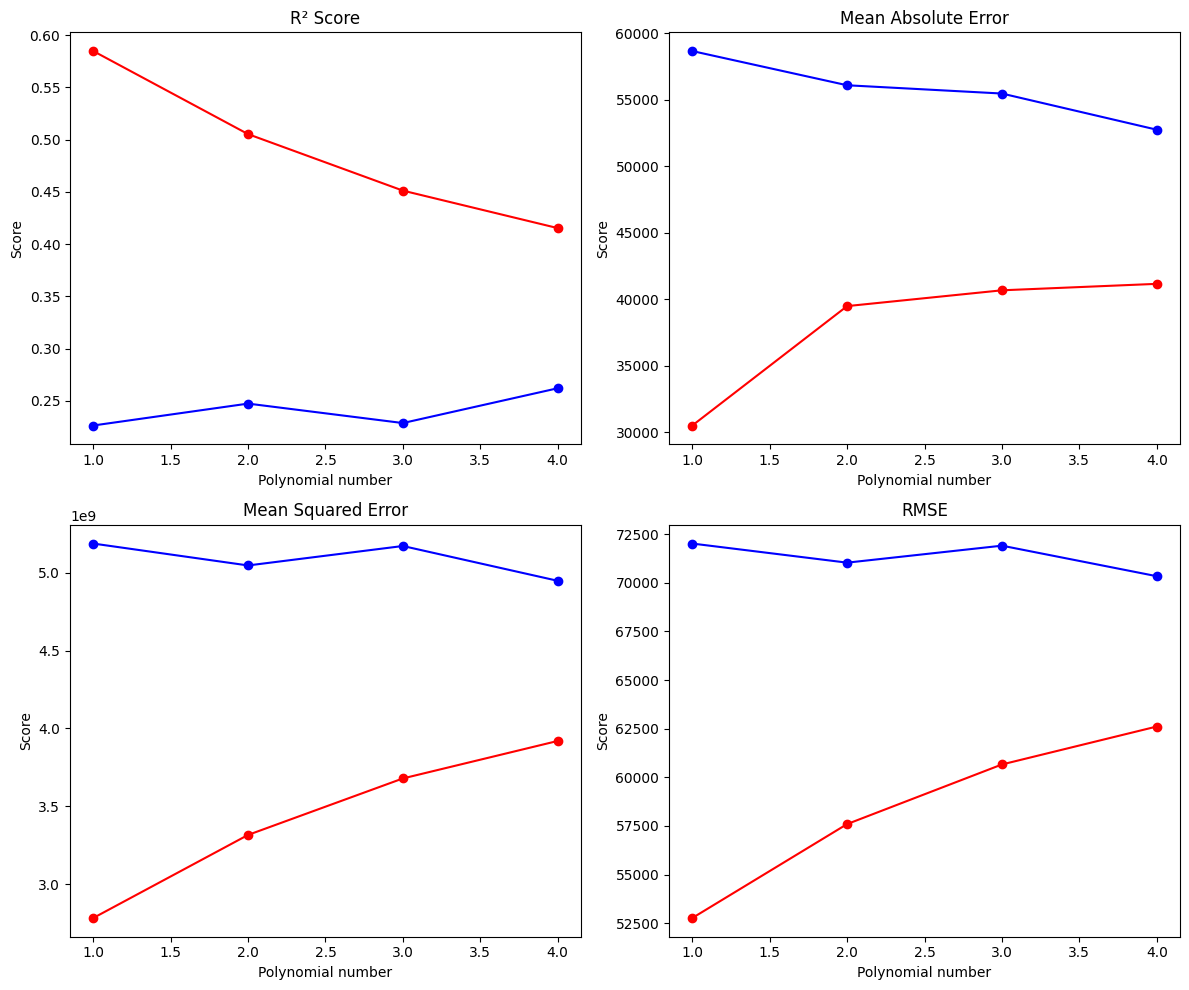

In [18]:
polys = [1,2,3,4]

r2_scores_with_bias = []
mean_absolute_errors_with_bias = []
mean_squared_errors_with_bias = []
rmses_with_bias = []
for _, poly in enumerate(polys):
    poly_model = LinearRegression(X_train_scaled.values, y_train.values, poly=poly, include_bias=True, regularization=True)
    poly_model.fit(0.1)
    y_test_pred = poly_model.predict(X_test_scaled.values)
    
    r2_scores_with_bias.append(r2_score(y_test.values, y_test_pred))
    mean_absolute_errors_with_bias.append(mean_absolute_error(y_test.values, y_test_pred))
    mean_squared_errors_with_bias.append(mean_squared_error(y_test.values, y_test_pred))
    rmses_with_bias.append(sqrt(mean_squared_error(y_test.values, y_test_pred)))
    

# 定义评估指标及对应的标题和颜色
metrics = [r2_scores, mean_absolute_errors, mean_squared_errors, rmses]
metrics_bias = [r2_scores_with_bias, mean_absolute_errors_with_bias, mean_squared_errors_with_bias, rmses_with_bias]
metric_titles = ['R² Score', 'Mean Absolute Error', 'Mean Squared Error', 'RMSE']

# 创建四个子图
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 绘制每个指标的折线图
for i, (metric, metric_bias, title) in enumerate(zip(metrics, metrics_bias, metric_titles)):
    ax = axs[i // 2, i % 2]
    ax.plot(polys, metric, color='red', marker='o')  # 使用不同的颜色和标记
    ax.plot(polys, metric_bias, color='blue', marker='o')  # 使用不同的颜色和标记
    ax.set_title(title)
    ax.set_xlabel('Polynomial number')
    ax.set_ylabel('Score')
    #ax.set_ylim(0, max(max(metric) * 1.1, 1))  # 根据最大值设置 y 轴范围

# 调整布局
plt.tight_layout()
# 显示图形
plt.show()

## 实验3：不同的学习率
> 学习率是梯度下降法中非常重要的参数之一，它控制模型在每次迭代中更新参数的步长。 此实验在多项式特征系数为2，不含偏置项，迭代次数为6000的情况下进行。

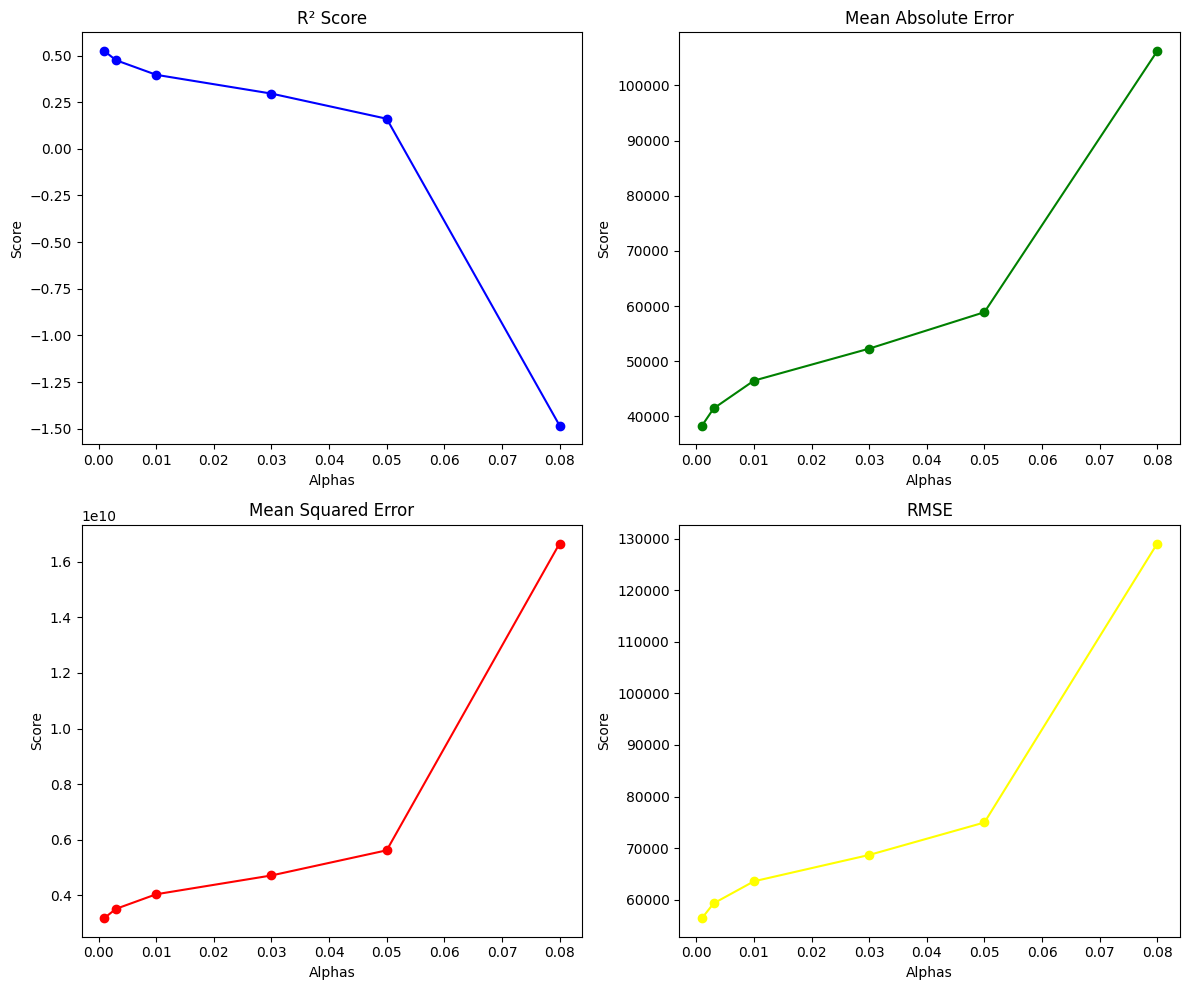

In [19]:
alphas = [0.001, 0.003, 0.01, 0.03, 0.05, 0.08]

r2_scores = []
mean_absolute_errors = []
mean_squared_errors = []
rmses = []
for _, alpha in enumerate(alphas):
    poly_model = LinearRegression(X_train_scaled.values, y_train.values, poly=2, include_bias=False, regularization=True)
    #poly_model.fit()
    theta, cost_history = poly_model.train(alpha=alpha, num_iterations=6000, lamda=0.1)
    y_test_pred = poly_model.predict(X_test_scaled.values)
    
    #poly_model.plot_final_cost_history()
    
    r2_scores.append(r2_score(y_test.values, y_test_pred))
    mean_absolute_errors.append(mean_absolute_error(y_test.values, y_test_pred))
    mean_squared_errors.append(mean_squared_error(y_test.values, y_test_pred))
    rmses.append(sqrt(mean_squared_error(y_test.values, y_test_pred)))
    
    
# 定义评估指标及对应的标题和颜色
metrics = [r2_scores, mean_absolute_errors, mean_squared_errors, rmses]
metric_titles = ['R² Score', 'Mean Absolute Error', 'Mean Squared Error', 'RMSE']
colors = ['blue', 'green', 'red', 'yellow']  # 为每个指标分配不同的颜色

# 创建四个子图
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 绘制每个指标的折线图
for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axs[i // 2, i % 2]
    ax.plot(alphas, metric, color=colors[i % len(colors)], marker='o')  # 使用不同的颜色和标记
    ax.set_title(title)
    ax.set_xlabel('Alphas')
    ax.set_ylabel('Score')
    #ax.set_ylim(0, max(max(metric) * 1.1, 1))  # 根据最大值设置 y 轴范围

# 调整布局
plt.tight_layout()
# 显示图形
plt.show()

## 实验4：不同的迭代次数
> 迭代次数是梯度下降法中非常重要的参数之一，它控制模型在训练集上的训练轮数。 此实验在多项式特征系数为2，不含偏置项的情况下进行。
由于图像数量比较多，这里只绘制R^2的图像

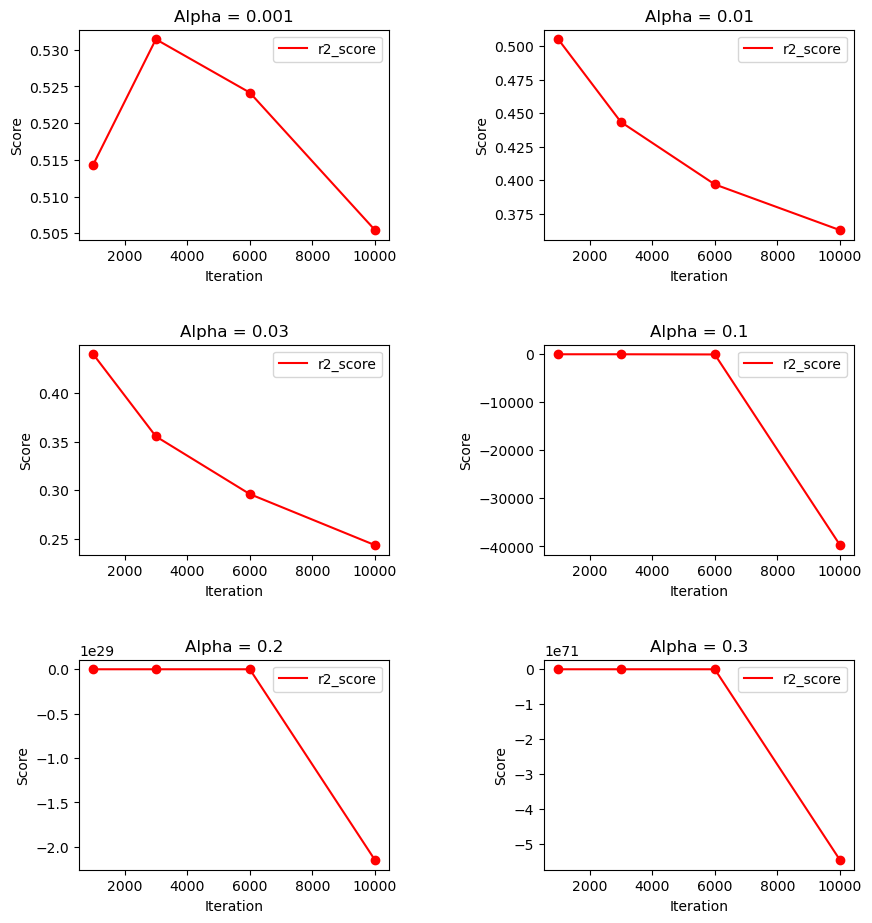

In [151]:
iterations = [1000, 3000, 6000, 10000]
alphas = [0.001, 0.01, 0.03, 0.1, 0.2, 0.3]

plt.figure(figsize=(10, 15))
for n, alpha in enumerate(alphas):
    plt.subplot(4, 2, n + 1)
    plt.title(f'Alpha = {alpha}')
    
    r2_scores = []
    mean_absolute_errors = []
    mean_squared_errors = []
    rmses = []
    for _, iteration in enumerate(iterations):
        poly_model = LinearRegression(X_train_scaled.values, y_train.values, poly=2, include_bias=False, regularization=True)
        #poly_model.fit()
        theta, cost_history = poly_model.train(alpha=alpha, num_iterations=iteration, lamda=0.1)
        y_test_pred = poly_model.predict(X_test_scaled.values)
        
        #poly_model.plot_final_cost_history()

        r2_scores.append(r2_score(y_test.values, y_test_pred))
        mean_absolute_errors.append(mean_absolute_error(y_test.values, y_test_pred))
        mean_squared_errors.append(mean_squared_error(y_test.values, y_test_pred))
        rmses.append(sqrt(mean_squared_error(y_test.values, y_test_pred)))

    
    # 绘制折线图
    plt.plot(iterations, r2_scores, label='r2_score', color='red')
    #plt.plot(iterations, mean_absolute_errors, label='mean_absolute_error', color='blue')
    #plt.plot(iterations, mean_squared_errors, label='mean_squared_error', color='yellow')
    #plt.plot(iterations, rmses, label='rmse', color='green')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    
    # 标出数据点
    for i in range(len(iterations)):
        plt.scatter(iterations[i], r2_scores[i], color='red')
        #plt.scatter(iterations[i], mean_absolute_errors[i], color='blue')
        #plt.scatter(iterations[i], mean_squared_errors[i], color='yellow')
        #plt.scatter(iterations[i], rmses[i], color='green')
    
    plt.legend()
    
# 调整子图间距
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## 实验5：不同正则化参数
> 多项式回归模型中，正则化项的作用是通过对模型的复杂度进行控制，来避免模型过于复杂导致过拟合的问题。 为了结果可视化清晰，仅选择r2_score为度量标准，并使用了特定的正则化参数范围。
由于图像数量比较多，这里只绘制R^2的图像

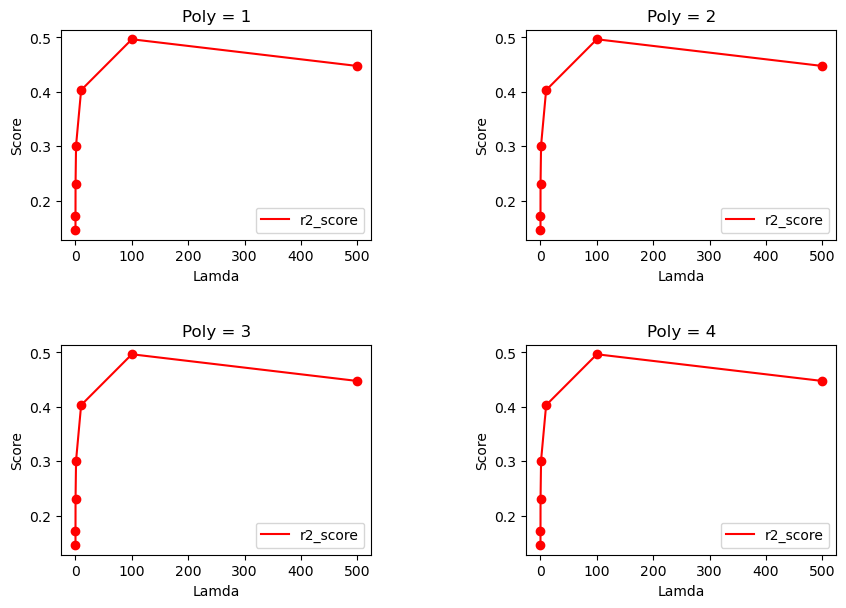

In [152]:
polys = [1, 2, 3, 4]
lamdas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,500.0]

plt.figure(figsize=(10, 15))
for n, poly in enumerate(polys):
    plt.subplot(4, 2, n + 1)
    plt.title(f'Poly = {poly}')
    
    r2_scores = []
    for _, lamda in enumerate(lamdas):
        poly_model = LinearRegression(X_train_scaled.values, y_train.values, poly=2, include_bias=False, regularization=True)
        poly_model.fit(lamda=lamda)
        y_test_pred = poly_model.predict(X_test_scaled.values)
        r2_scores.append(r2_score(y_test.values, y_test_pred))
    
    # 绘制折线图
    plt.plot(lamdas, r2_scores, label='r2_score', color='red')
    plt.xlabel('Lamda')
    plt.ylabel('Score')
    
    # 标出数据点
    for i in range(len(lamdas)):
        plt.scatter(lamdas[i], r2_scores[i], color='red')
    
    plt.legend()
    
# 调整子图间距
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()